# Plotting and comparing best fit models to data for fits to BAOs with and without the phase shift parameter 

### load stuff 

In [1]:
# Import some necessary modules
import os
import sys
sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     
from barry.cosmology.camb_generator import Omega_m_z


from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

# settings 
CV = False 

### load in the data 

In [2]:

datafile="desi_kp4_abacus_cubicbox_pk_elg.pkl"

if CV:
    datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl"


dataset_pk = PowerSpectrum_DESI_KP4(
recon='sym',
fit_poles=[0, 2],
min_k=0.02,
max_k=0.30,
realisation=None,          # realisation=None loads the average of all the realisations
num_mocks=1000,            # Used for Hartlap/Sellentin correction if correction=Correction.HARTLAP or Correction.SELLENTIN
reduce_cov_factor=1,       # if = 1 Use standard covariance, even for the average
datafile=datafile,#"desi_kp4_abacus_cubicbox_pk_elg.pkl",
#datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl",   
data_location="/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles",
)

dataset_pk.set_realisation(None)

# print(dir(dataset_pk)) # attributes 

# print(dataset_pk.data.shape) # number of k measurements vs number of multipoles 
# print(dataset_pk.ks.shape)

# print(dataset_pk.w_pk.shape)


# print(dataset_pk.get_data()[0].keys())#[0]['pk'])#[['ndata']])#[['pk']])
# print(dataset_pk.get_data()[0]['w_scale'].shape)#[0]['pk'])#[['ndata']])#[['pk']])

# #plt.plot(dataset_pk.get_data()[0]['pk0'][0], dataset_pk.data[:,0]) # both of these give the monopole
# #plt.show()
# # print(dataset_pk.m_w_transform.shape)
# print(dataset_pk.w_transform.shape)

# # print(dataset_pk.w_transform.shape)

# # print(dataset_pk.ks.shape)
# # print(dataset_pk.m_w_mask.shape)

# # print(dataset_pk.w_pk.shape)
# print(dataset_pk.w_ks_input.shape)
# print(dataset_pk.w_ks_output.shape)

# #print(dataset_pk.get_data()[0][''])


### set up default model (what the best fit should be) 

6.791932657246971


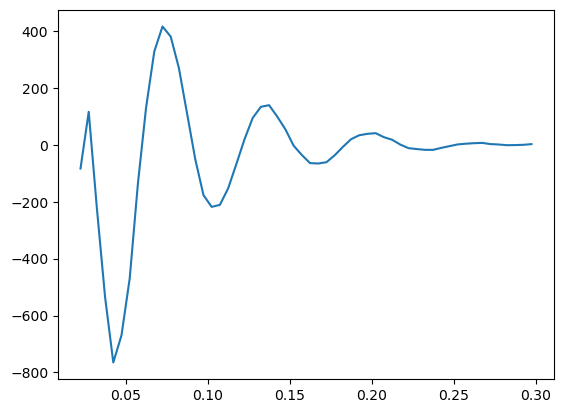

In [13]:
# generating the default (correct) model for the data 
model = PowerBeutler2017(
                recon='sym',                   
                isotropic=False,
                n_poly=6,                                 # 6 polynomial terms for P(k)
                vary_phase_shift_neff=True, 
                use_classorcamb='CLASS',
                dilate_smooth=True,
                marg='full'
)
sigma_nl_par = {None: 8.7, "sym": 5.4}
sigma_nl_perp = {None: 4.0, "sym": 1.5}
sigma_s = {None: 3.5, "sym": 0.0}

# sigma_nl_par = {None: 8.35, "sym": 5.59}
# sigma_nl_perp = {None: 4.35, "sym": 1.21}
# sigma_s = {None: 7.05, "sym": 1.346}
# print(model.get_param('beta'))

model.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
#model.set_default('b{0}_{1}', 1.0)

#2.083e-09 67.36 0.049301692328524445 0.9649
cosmology = {
            "om": 0.3152,
            "h0": 0.6736,
            "z":  0.51,
            "ob": 0.0493,
            "ns": 0.9649,
            "mnu": 0.06,
            "reconsmoothscale": 15,
            "Neff": 3.044,
        }
model.set_cosmology(cosmology) # initialises self.camb object 
#model.camb._generate_data()
model.camb.get_data()
model.set_data(dataset_pk.get_data())
ks = model.camb.ks
params_dict = {j.name: j.default for j in model.params}
#params_dict['b{0}_{1}'] = 1.0
#print(model.redshift)
# kd, pkdsmooth, poly = model.compute_power_spectrum(ks, params_dict, smooth=True)
# kd, pkd, poly = model.compute_power_spectrum(ks, params_dict)

# print(dir(dataset_pk))
# wigglesmonomodel = pkd[0]/pkdsmooth[0]
#print(pkd)

# data = model.get_model(params_dict, dataset_pk.get_data()[0])
# data_smooth = model.get_model(params_dict, dataset_pk.get_data()[0], smooth=True)
# print(len(data))

# plt.plot(dataset_pk.w_ks_output, data[0][:160] * dataset_pk.w_ks_output)#/data_smooth[0][:160])
# plt.errorbar(dataset_pk.ks, dataset_pk.data[:,0] * dataset_pk.ks,#/pk_smooth_data, 
#              err * dataset_pk.ks,
#              label='data', color='grey', linestyle='--', 
#     markersize = 4, marker='o')
# plt.xlim(np.min(dataset_pk.ks), np.max(dataset_pk.ks))
# #plt.ylim(np.min(dataset_pk.data[:,0]), np.max(dataset_pk.data[:,0]))

#model.plot(params_dict)

new_chi_squared_default, dof, bband, mods_default, smooths_default = model.get_model_summary(params_dict)

# print(smooths[0][0])

print(new_chi_squared_default)

plt.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_default[0][0])



### set up the best fit model of mock mean for alphas and phase shift - DESI KP4 Abacus CubicBox Pk ELG Recon mock

6.9031726701602105


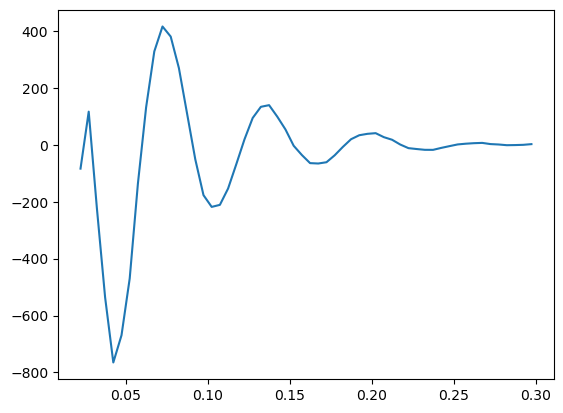

In [14]:
# generating the default (correct) model for the data 
# best fit for non CV mocks 

if not CV:
    modelBF = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    vary_phase_shift_neff=True, 
                    use_classorcamb='CLASS', 
                    marg='full',
    )
    sigma_nl_par = {None: 8.35, "sym": 5.682}
    sigma_nl_perp = {None: 4.35, "sym": 1.501}
    sigma_s = {None: 7.05, "sym": 1.802}

    modelBF.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF.set_default("alpha", 1.001, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF.set_default("epsilon", 3.522e-05, min=0.0, max=1.0, prior='flat')
    modelBF.set_default("beta_phase_shift", 1.079, min=0.0, max=2.5, sigma=1.0, prior='gaussian')


    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF.camb._generate_data()
    modelBF.camb.get_data()
    modelBF.set_data(dataset_pk.get_data())
    params_dict = {j.name: j.default for j in modelBF.params}
    ks = modelBF.camb.ks
    # params_dict['beta'] = 0.7998

    #kbf, pkbf, poly = modelBF.compute_power_spectrum(ks, params_dict)
    #kbf, pkbfsmooth, poly = modelBF.compute_power_spectrum(ks, params_dict, smooth=True)

    # wigglesmodelBFmonopole = pkbf[0]/pkbfsmooth[0]
    
    new_chi_squared_BF, dof, bband, modsBF, smooths_BF = modelBF.get_model_summary(params_dict)
    


# best fit for CV 
if CV: 
    modelBF = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    vary_phase_shift_neff=True, 
                    use_classorcamb='CLASS',
                    marg='full'
    )
    sigma_nl_par = {None: 8.35, "sym": 5.452}
    sigma_nl_perp = {None: 4.35, "sym": 1.551}
    sigma_s = {None: 7.05, "sym": 3.333}

    modelBF.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF.set_default("alpha", 0.9975, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF.set_default("epsilon", -0.0001655, min=0.0, max=1.0, prior='flat')
    modelBF.set_default("beta_phase_shift", 0.7321, min=0.0, max=2.5, sigma=1.0, prior='gaussian')


    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF.camb._generate_data()
    modelBF.camb.get_data()
    ks = modelBF.camb.ks
    modelBF.set_data(dataset_pk.get_data())
    params_dict = {j.name: j.default for j in modelBF.params}
    # params_dict['beta'] = 0.7831

    new_chi_squared_BF, dof, bband, modsBF, smooths_BF = modelBF.get_model_summary(params_dict)
    
    # kbf, pkbf, poly = modelBF.compute_power_spectrum(ks, params_dict)
    # kbf, pkbfsmooth, poly = modelBF.compute_power_spectrum(ks, params_dict, smooth=True)

    # wigglesmodelBFmonopole = pkbf[0]/pkbfsmooth[0]
    
#print(kbf)
#print(pkbfsmooth[0])
#modelBF.plot(params_dict)

print(new_chi_squared_BF)

plt.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_BF[0][0])


### best fit model of mock mean when phase shift doesn't vary 

6.792082901676833


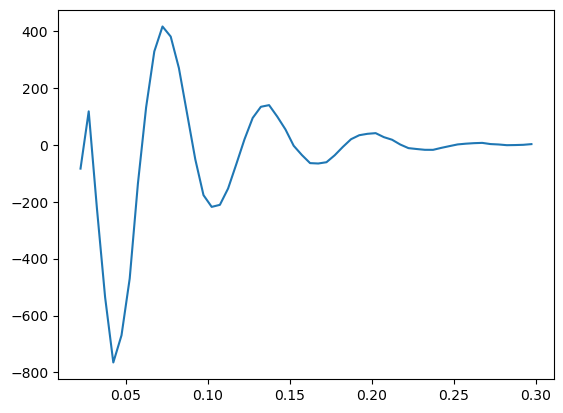

In [15]:

if not CV: 
    modelBF2 = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    marg='full',
    )

    sigma_nl_par = {None: 8.35, "sym": 5.302}
    sigma_nl_perp = {None: 4.35, "sym": 1.494}
    sigma_s = {None: 7.05, "sym": 0.4097}

    modelBF2.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF2.set_default("alpha", 1.001, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF2.set_default("epsilon", -0.0006434, min=0.0, max=1.0, prior='flat')

    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF2.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF2.camb._generate_data()
    modelBF2.camb.get_data()
    ks = modelBF2.camb.ks
    modelBF2.set_data(dataset_pk.get_data())
    #params_dict['beta'] = 0.7475
    params_dict = {j.name: j.default for j in modelBF2.params}

    #kbf2, pkbf2, poly = modelBF2.compute_power_spectrum(ks, params_dict)
    #kbf2, pkbfsmooth2, poly = modelBF2.compute_power_spectrum(ks, params_dict, smooth=True)

    # wigglesmodelBF2monopole = pkbf2[0]/pkbfsmooth2[0]
    
    new_chi_squared_BF2, dof, bband, modsBF2, smooths_BF2 = modelBF2.get_model_summary(params_dict)
    
    
if CV: 
    modelBF2 = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    marg='full',
    )

    sigma_nl_par = {None: 8.35, "sym": 5.148}
    sigma_nl_perp = {None: 4.35, "sym": 2.456}
    sigma_s = {None: 7.05, "sym": 0.9935}

    modelBF2.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF2.set_default("alpha", 0.9996, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF2.set_default("epsilon", 0.0003904, min=0.0, max=1.0, prior='flat')

    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF2.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF2.camb._generate_data()
    modelBF2.camb.get_data()
    ks = modelBF2.camb.ks
    modelBF2.set_data(dataset_pk.get_data())
    # params_dict['beta'] = 0.7325
    params_dict = {j.name: j.default for j in modelBF2.params}

    #kbf2, pkbf2, poly = modelBF2.compute_power_spectrum(ks, params_dict)
    #kbf2, pkbfsmooth2, poly = modelBF2.compute_power_spectrum(ks, params_dict, smooth=True)

    # wigglesmodelBF2monopole = pkbf2[0]/pkbfsmooth2[0]
    new_chi_squared_BF2, dof, bband, modsBF2, smooths_BF2 = modelBF2.get_model_summary(params_dict)
    
# modelBF2.plot(params_dict)


print(new_chi_squared_BF2)

plt.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_BF2[0][0])



### model corresponding to average of all fits to mocks WITH phi phase shift (both CV and non CV Pk ELG fits)

7.011081295388877


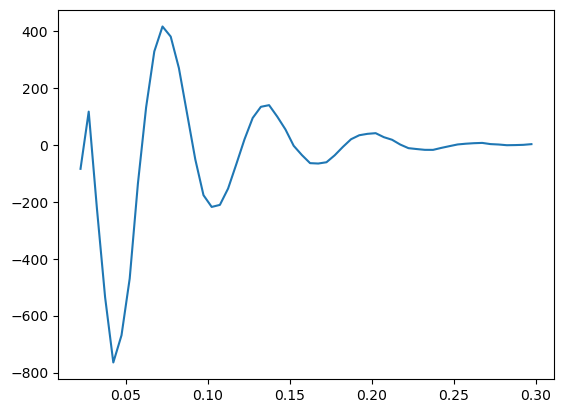

In [16]:
# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <phi>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_phi>, <corr_alpha_par_perp>, <corr_alpha_par_phi>, <corr_alpha_perp_phi>, std_alpha_par, std_alpha_perp, std_phi, corr_alpha_par_perp, corr_alpha_par_phi, corr_alpha_perp_phi, <bf_chi2>
# 0.9994, 0.9993, 5.2030, 1.4447, 0.9102, 0.0027, 0.0022, 0.1840, 0.6387, 0.8141, 0.9165, 0.0118, 0.0103, 0.8259, 0.7142, 0.8267,0.9344, 1672.601

# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <phi>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_phi>, <corr_alpha_par_perp>, <corr_alpha_par_phi>, <corr_alpha_perp_phi>, std_alpha_par, std_alpha_perp, std_phi, corr_alpha_par_perp, corr_alpha_par_phi, corr_alpha_perp_phi, <bf_chi2>
# 0.9994, 0.9993, 5.2036, 1.4440, 0.9097, 0.0027, 0.0022, 0.1837, 0.6368, 0.8149, 0.9156, 0.0118, 0.0103, 0.8256, 0.7136, 0.8263,0.9342, 1672.552

modelav = PowerBeutler2017(
                recon='sym',                   
                isotropic=False,                          # Analytic marginalisation
                n_poly=6,                                 # 6 polynomial terms for P(k)
                vary_phase_shift_neff=True, 
                use_classorcamb='CLASS',
                marg='full'
)

sigma_nl_par = {None: 8.35, "sym": 5.2036}
sigma_nl_perp = {None: 4.35, "sym": 1.444}
sigma_s = {None: 7.05, "sym": 3.4857} 

alpha, epsilon = modelav.get_reverse_alphas(0.9994, 0.9993)

modelav.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
modelav.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
modelav.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

modelav.set_default("alpha", alpha, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
modelav.set_default("epsilon", epsilon, min=0.0, max=1.0, prior='flat')
modelav.set_default("beta_phase_shift", 0.9097, min=0.0, max=2.5, sigma=1.0, prior='gaussian')

cosmology = {
            "om": 0.3152,
            "h0": 0.6736,
            "z":  0.51,
            "ob": 0.0493,
            "ns": 0.9649,
            "mnu": 0.06,
            "reconsmoothscale": 15,
            "Neff": 3.046,
        }
modelav.set_cosmology(cosmology) # initialises self.camb object 
#modelav.camb._generate_data()
modelav.camb.get_data()
ks = modelav.camb.ks
modelav.set_data(dataset_pk.get_data())
params_dict = {j.name: j.default for j in modelav.params}
#params_dict['beta'] = 0.75165

#kav, pkav, poly = modelav.compute_power_spectrum(ks, params_dict)
#kav, pksmoothav, poly = modelav.compute_power_spectrum(ks, params_dict, smooth=True)

#wigglesmodelavmonopole = pkav[0]/pksmoothav[0]

new_chi_squared_av, dof, bband, modsav, smooths_av = modelav.get_model_summary(params_dict)

print(new_chi_squared_av)

plt.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_av[0][0])

# modelav.plot(params_dict)

### model corresponding to average of all fits to mocks (both CV and non CV Pk ELG fits)

510.3666648301279


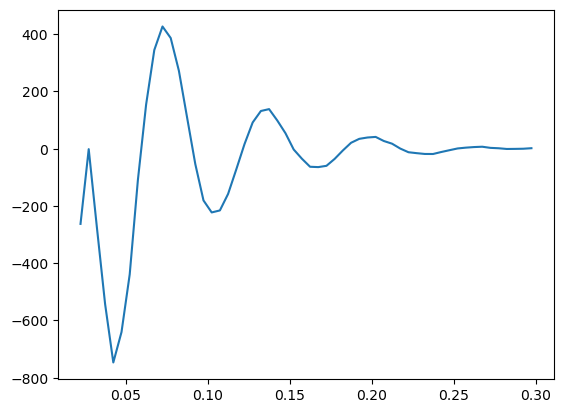

In [17]:
# generating the default (correct) model for the data 
# best fit for non CV mocks 

# best fit for CV 
#  <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <sigma_alpha_par>, <sigma_alpha_perp>, <corr_alpha_par_perp>, std_alpha_par, std_alpha_perp, corr_alpha_par_perp, <bf_chi2>
# 1.0003, 1.0004, 5.1090, 1.8920, 0.0078, 0.0044, -0.4607, 0.0067, 0.0037, -0.2597,  66.591

# checking data smoothing 
# check model window function convolution? 

modelav2 = PowerBeutler2017(
                recon='sym',                   
                isotropic=False,                          # Analytic marginalisation
                n_poly=6,                                 # 6 polynomial terms for P(k)
                marg='full',
)

alpha, epsilon = modelav2.get_reverse_alphas(1.0003, 1.0004)

sigma_nl_par = {None: 8.35, "sym": 5.109}
sigma_nl_perp = {None: 4.35, "sym": 1.892}
sigma_s = {None: 7.05, "sym": 2.123} 

modelav2.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
modelav2.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
modelav2.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

modelav2.set_default("alpha", alpha, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
modelav2.set_default("epsilon", alpha, min=0.0, max=1.0, prior='flat')

cosmology = {
            "om": 0.3152,
            "h0": 0.6736,
            "z":  0.51,
            "ob": 0.0493,
            "ns": 0.9649,
            "mnu": 0.06,
            "reconsmoothscale": 15,
            "Neff": 3.046,
        }
modelav2.set_cosmology(cosmology) # initialises self.camb object 
#modelav2.camb._generate_data()
modelav2.camb.get_data()
ks = modelav2.camb.ks
modelav2.set_data(dataset_pk.get_data())
params_dict = {j.name: j.default for j in modelav2.params}
#params_dict['beta'] = 0.7305
#params_dict['b{0}_{1}'] = 1.0
#print(params_dict)


new_chi_squared_av2, dof, bband, modsav2, smooths_av2 = modelav2.get_model_summary(params_dict)

print(new_chi_squared_av2)

plt.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_av2[0][0])

# kav2, pkav2, poly = modelav2.compute_power_spectrum(ks, params_dict)
# kav2, pksmoothav2, poly = modelav2.compute_power_spectrum(ks, params_dict, smooth=True)


#wigglesmodelav2monopole = pkav2[0]/pksmoothav2[0]

#modelav2.plot(params_dict)


### plot the data, plot the default model, plot the best fit model 

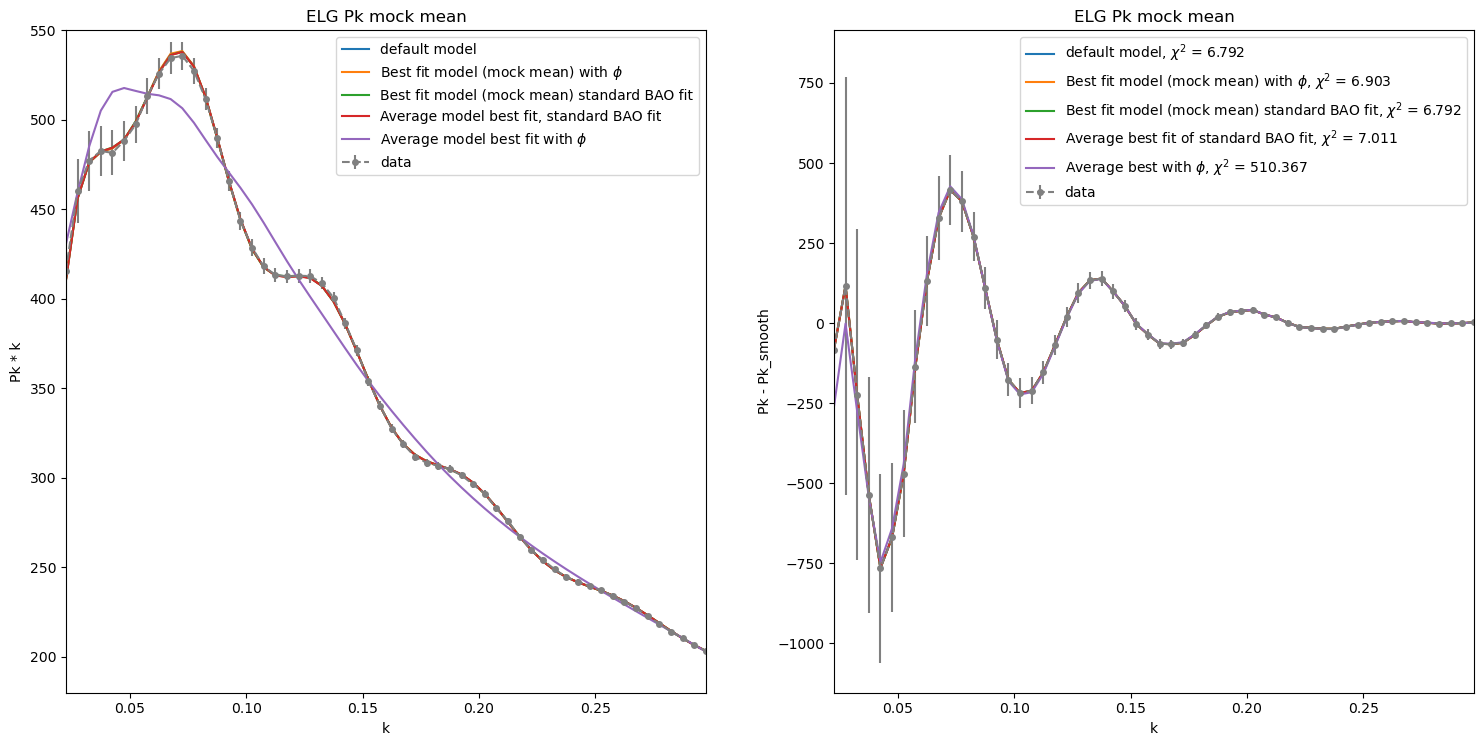

In [18]:
err = np.sqrt(np.diag(dataset_pk.cov[0:56,0:56]))

# make an interpolator 
from scipy.interpolate import CubicSpline 
#interp = CubicSpline(kd[:,0], pk1[0])

# from barry.cosmology.power_spectrum_smoothing import smooth_func, validate_smooth_method # for smoothing data for plot 

# pk_smooth_data = smooth_func(
#             dataset_pk.ks, 
#             dataset_pk.data[:,0], 
#             om=0.3152,
#             h0=0.7636,
#             ob=0.0493,
#             ns=0.9649,
#             rs=modelBF2.camb.get_data()['r_s'],
#             Neff=3.046,
        # )  # Get the smoothed power spectrum


# calculate the chi squared for the different models 

# interp_default = CubicSpline(kd[:,0], pkd[0]-pkdsmooth[0])
# interp_bestfit = CubicSpline(kbf[:,0], pkbf[0]-pkbfsmooth[0])
# interp_bestfit_2 = CubicSpline(kbf2[:,0], pkbf2[0]-pkbfsmooth2[0])
# interp_av_2 = CubicSpline(kav2[:,0], pkav2[0]-pksmoothav2[0])
# interp_av = CubicSpline(kav[:,0], pkav[0]-pksmoothav[0])


# default_pk_vals = interp_default(dataset_pk.ks)
# bestfit_pk_vals = interp_bestfit(dataset_pk.ks)
# bestfit2_pk_vals = interp_bestfit_2(dataset_pk.ks)
# av2_pk_vals = interp_av_2(dataset_pk.ks)
# av_pk_vals = interp_av(dataset_pk.ks)

# now need to adjust each model for the appropriate window function 
#default_pk_vals = model.adjust_model_window_effects(default_pk_vals, data_stuff_for_window_adjust)


# # calculate chi squares 
# chi_square_default = np.sum( (( default_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 
# chi_square_bestfit = np.sum( (( bestfit_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 
# chi_square_bestfit_2 = np.sum( (( bestfit2_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 
# chi_square_av_2 = np.sum( (( av2_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 
# chi_square_av = np.sum( (( av_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 


# reduced_chisquare_default = chi_square_default/ (len(dataset_pk.ks - 7.0 ))
# reduced_chisquare_bestfit = chi_square_bestfit/ (len(dataset_pk.ks - 7.0 ))
# reduced_chisquare_bestfit_2 = chi_square_bestfit_2/ (len(dataset_pk.ks - 6.0 ))
# reduced_chisquare_av_2 = chi_square_av_2/ (len(dataset_pk.ks - 6.0 ))
# reduced_chisquare_av = chi_square_av/ (len(dataset_pk.ks - 6.0 ))


f, (ax1, ax2) = plt.subplots(1,2, sharex=True)


ax1.errorbar(dataset_pk.ks, dataset_pk.data[:,0] * dataset_pk.ks, err * dataset_pk.ks, 
             label='data', color='grey', linestyle='--', 
    markersize = 4, marker='o')
ax1.plot(dataset_pk.ks, mods_default[0][0] * dataset_pk.ks, label=r'default model')
ax1.plot(dataset_pk.ks, modsBF[0][0] * dataset_pk.ks, label=r'Best fit model (mock mean) with $\phi$')
ax1.plot(dataset_pk.ks, modsBF2[0][0] * dataset_pk.ks, label=r'Best fit model (mock mean) standard BAO fit')
ax1.plot(dataset_pk.ks, modsav[0][0] * dataset_pk.ks, label=r'Average model best fit, standard BAO fit')
ax1.plot(dataset_pk.ks, modsav2[0][0] * dataset_pk.ks, label=r'Average model best fit with $\phi$')

ax1.legend()
ax1.set_title("ELG Pk mock mean")
if CV:
    ax1.set_title("ELG CV Pk mock mean")
ax1.set_xlim(np.min(dataset_pk.ks), np.max(dataset_pk.ks))
ax1.set_ylim(180, 550)

ax1.set_ylabel('Pk * k')
ax1.set_xlabel('k')

ax2.errorbar(dataset_pk.ks, dataset_pk.data[:,0]-smooths_default[0][0], err, label='data', color='grey', linestyle='--', 
    markersize = 4, marker='o')

ax2.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_default[0][0], label=r'default model, $\chi^2$ = %.3f' % new_chi_squared_default)
ax2.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_BF[0][0], label=r'Best fit model (mock mean) with $\phi$, $\chi^2$ = %.3f' % new_chi_squared_BF)
ax2.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_BF2[0][0], label=r'Best fit model (mock mean) standard BAO fit, $\chi^2$ = %.3f' % new_chi_squared_BF2)
ax2.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_av[0][0], label=r'Average best fit of standard BAO fit, $\chi^2$ = %.3f' % new_chi_squared_av)
ax2.plot(dataset_pk.ks, dataset_pk.data[:,0]-smooths_av2[0][0], label=r'Average best with $\phi$, $\chi^2$ = %.3f' % new_chi_squared_av2)

ax2.legend()
ax2.set_title("ELG Pk mock mean")
if CV:
    ax2.set_title("ELG CV Pk mock mean")
ax2.set_xlim(np.min(dataset_pk.ks), np.max(dataset_pk.ks))
ax2.set_ylabel('Pk - Pk_smooth')
ax2.set_xlabel('k')

plt.subplots_adjust(right=2, left=-0.2, bottom =-0.5)
# plt.show()

